In [1]:
import mxnet as mx
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [2]:
def decodeBox(yolobox, size, dscale):
    i, j, cx, cy, w, h = yolobox
    cxt = j*dscale + cx*dscale
    cyt = i*dscale + cy*dscale
    wt = w*size
    ht = h*size
    return [cxt, cyt, wt, ht]


def bboxdraw(img, label, dscale=32):
    assert label.shape == (7,7,5)
    size = img.shape[1]
    ilist, jlist = np.where(label[:,:,0] > 0.5)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    for i,j in zip(ilist, jlist): 
        cx,cy,w,h = label[i,j,1:]
        cxt, cyt, wt ,ht = decodeBox([i, j, cx,cy,w,h], size, dscale)
        # Create a Rectangle patch
        rect = patches.Rectangle((cxt-wt/2,cyt-ht/2), wt,ht,linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.plot(int(cxt), int(cyt), '*')

    plt.show()

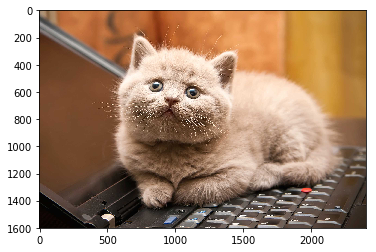

=== Original Cat ===


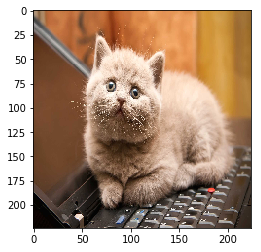

=== Resized Cat ===
The type of input dataset is <class 'mxnet.io.NDArrayIter'>


In [3]:
# check random image inference
cat = plt.imread("cat.jpg")
plt.imshow(cat)
plt.show()
print "=== Original Cat ==="

W = 224
H = 224
cat_resize = cv2.resize(cat, (H, W))
plt.imshow(cat_resize)
plt.show()
print "=== Resized Cat ==="

cat_mxnd = mx.nd.array(ctx=mx.cpu(), source_array=cat_resize.transpose((2,0,1)).reshape((1,3,H,W)))
img_itr = mx.io.NDArrayIter(data=cat_mxnd, data_name='data', batch_size=1)
print "The type of input dataset is", type(img_itr)

In [4]:
# get sym from pretrained model
sym, arg_params, aux_params = mx.model.load_checkpoint('models/cat_detect_full_scale', 600)
logit = sym.get_internals()['logit_output']
mod = mx.mod.Module(symbol=logit, context=mx.cpu(0))
mod.bind(img_itr.provide_data)
mod.init_params(mx.init.Xavier(rnd_type='gaussian', factor_type='in', magnitude=2),arg_params=arg_params, aux_params=aux_params)
out = mod.predict(eval_data=img_itr, num_batch=10)
pred = out.asnumpy()[0] + 1 / 2  # transform data from -1 ~ 1 to 0 ~ 1
print pred.shape

/Users/yyc/env/mxnet/lib/python2.7/site-packages/mxnet/module/base_module.py:52: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/Users/yyc/env/mxnet/lib/python2.7/site-packages/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


(7, 7, 5)


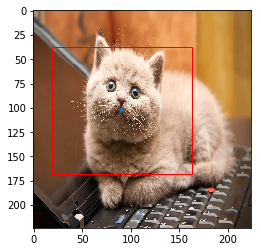

In [5]:
# prediction the box position
bboxdraw(cat_resize, pred)